In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Data Cleaning
# Load the dataset
data = pd.read_csv("Air_Quality.csv")

# Filter rows where 'Time Period' contains 'Annual Average'
filtered_data = data[data['Time Period'].str.contains("Annual Average", na=False)]

# Remove the 'Message' column
filtered_data = filtered_data.drop(columns=['Message'])

# Filter rows where 'Measure' is 'Mean'
filtered_data = filtered_data[filtered_data['Measure'] == "Mean"]

# Filter rows where 'Name' is "Fine particles (PM 2.5)" or "Nitrogen dioxide (NO2)"
filtered_data = filtered_data[filtered_data['Name'].isin(["Fine particles (PM 2.5)", "Nitrogen dioxide (NO2)"])]
print(filtered_data.head())

    Unique ID  Indicator ID                     Name Measure Measure Info  \
2      178540           365  Fine particles (PM 2.5)    Mean       mcg/m3   
3      178561           365  Fine particles (PM 2.5)    Mean       mcg/m3   
10     178582           365  Fine particles (PM 2.5)    Mean       mcg/m3   
11     178583           365  Fine particles (PM 2.5)    Mean       mcg/m3   
12     547477           365  Fine particles (PM 2.5)    Mean       mcg/m3   

   Geo Type Name  Geo Join ID                 Geo Place Name  \
2          UHF42        209.0        Bensonhurst - Bay Ridge   
3          UHF42        409.0               Southeast Queens   
10         UHF42        209.0        Bensonhurst - Bay Ridge   
11         UHF42        210.0  Coney Island - Sheepshead Bay   
12         UHF42        409.0               Southeast Queens   

            Time Period  Start_Date  Data Value  
2   Annual Average 2012  12/01/2011         8.6  
3   Annual Average 2012  12/01/2011         8.0  
10

In [9]:
# Create an additiona feature from attributes

# Ensure that the data is sorted by location, pollutant, and time period
filtered_data = filtered_data.sort_values(by=['Geo Place Name', 'Name', 'Time Period'])

# Calculate percentage change in Data Value for each pollutant over time
filtered_data['Pollution_Trend'] = (
    filtered_data.groupby(['Geo Place Name', 'Name'])['Data Value']
    .pct_change()
)

# Display the updated DataFrame with the new feature
print(filtered_data.head())

      Unique ID  Indicator ID                     Name Measure Measure Info  \
5143     170197           365  Fine particles (PM 2.5)    Mean       mcg/m3   
4552     170256           365  Fine particles (PM 2.5)    Mean       mcg/m3   
5142     170315           365  Fine particles (PM 2.5)    Mean       mcg/m3   
4870     170374           365  Fine particles (PM 2.5)    Mean       mcg/m3   
4866     170433           365  Fine particles (PM 2.5)    Mean       mcg/m3   

     Geo Type Name  Geo Join ID                      Geo Place Name  \
5143            CD        310.0  Bay Ridge and Dyker Heights (CD10)   
4552            CD        310.0  Bay Ridge and Dyker Heights (CD10)   
5142            CD        310.0  Bay Ridge and Dyker Heights (CD10)   
4870            CD        310.0  Bay Ridge and Dyker Heights (CD10)   
4866            CD        310.0  Bay Ridge and Dyker Heights (CD10)   

              Time Period  Start_Date  Data Value  Pollution_Trend  
5143  Annual Average 2009  12

In [ ]:
# Data Preparation for Clustering

from sklearn.preprocessing import StandardScaler

# Select relevant features 
features = ["Data Value", "Pollution_Trend"]

# Filter data for specific regions
regions = ["Bensonhurst - Bay Ridge", "Southeast Queens"]
region_filtered_data = filtered_data[filtered_data["Geo Place Name"].isin(regions)]

# Handle missing values (remove rows with missing values in the selected features)
region_filtered_data = region_filtered_data[features].dropna()

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(region_filtered_data)

# Convert scaled data back to a DataFrame for easier handling
scaled_data = pd.DataFrame(scaled_data, columns=features)
print(scaled_data.head())

   Data Value  Pollution_Trend
0   -0.460076         0.350930
1   -0.593595        -1.159697
2   -0.593595         0.350930
3   -0.479150         1.744274
4   -0.479150         0.350930


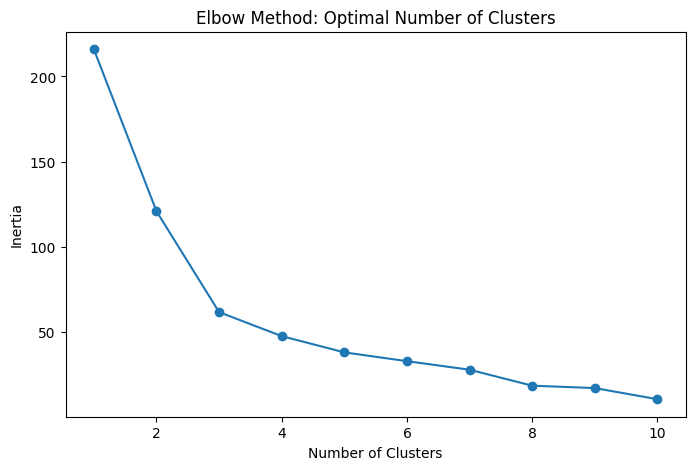

In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the optimal number of clusters using the Elbow Method
inertia = []
range_clusters = range(1, 11)  # Test from 1 to 10 clusters

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertia, marker='o')
plt.title('Elbow Method: Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


In [13]:
# Fit K-Means with the optimal number of clusters
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(scaled_data)

# Add cluster labels to the scaled data
scaled_data['Cluster'] = kmeans.labels_
print(scaled_data.head())


   Data Value  Pollution_Trend  Cluster
0   -0.460076         0.350930        1
1   -0.593595        -1.159697        2
2   -0.593595         0.350930        1
3   -0.479150         1.744274        1
4   -0.479150         0.350930        1


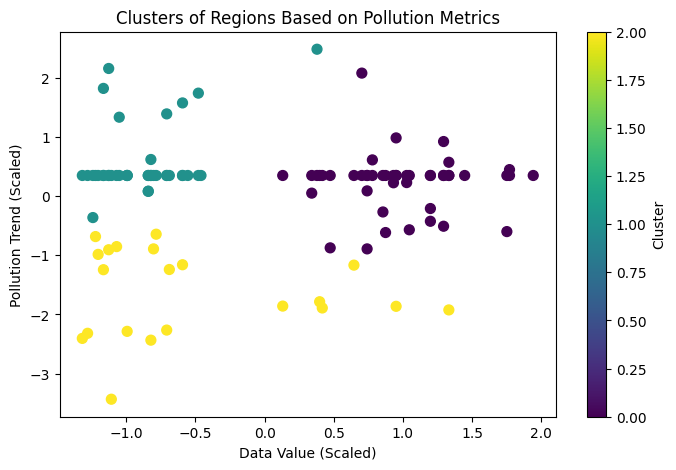

In [14]:
# Plot the clusters
plt.figure(figsize=(8, 5))
plt.scatter(scaled_data['Data Value'], scaled_data['Pollution_Trend'], c=scaled_data['Cluster'], cmap='viridis', s=50)
plt.title('Clusters of Regions Based on Pollution Metrics')
plt.xlabel('Data Value (Scaled)')
plt.ylabel('Pollution Trend (Scaled)')
plt.colorbar(label='Cluster')
plt.show()


In [15]:
# Add cluster labels to the original filtered data
region_filtered_data['Cluster'] = kmeans.labels_

# Display the original data with cluster labels
print(region_filtered_data.head())

      Data Value  Pollution_Trend  Cluster
8815         9.9         0.000000        1
6574         9.2        -0.070707        2
8132         9.2         0.000000        1
237          9.8         0.065217        1
8816         9.8         0.000000        1


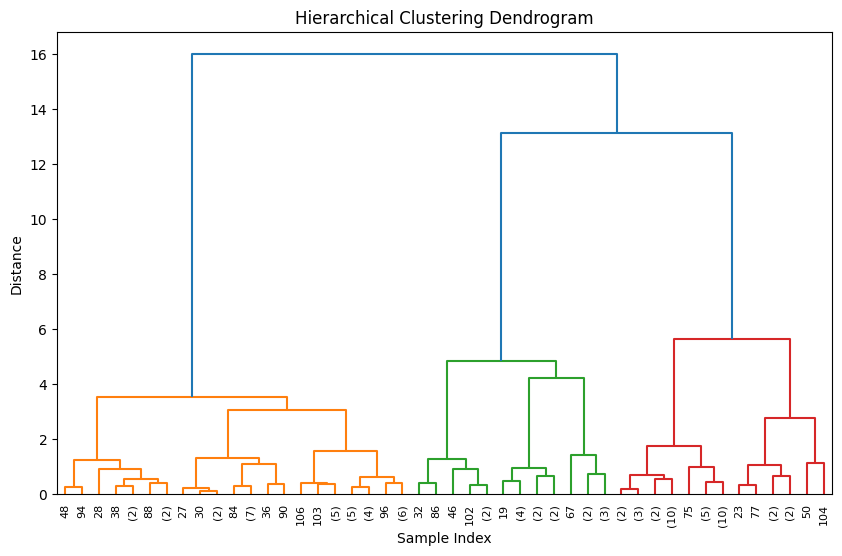

In [22]:
# Heirarchical Clustering

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# Create a linkage 
linkage_matrix = linkage(scaled_data, method='ward')  # 'ward' minimizes variance within clusters

# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=5)  # Truncate to show top 5 levels
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [24]:
# Fit Agglomerative Clustering with the chosen number of clusters
from sklearn.cluster import AgglomerativeClustering

n_clusters = 3  
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')

# Predict clusters
region_filtered_data['Cluster'] = agg_clustering.fit_predict(scaled_data)

# Display clustered data
print(region_filtered_data.head())


      Data Value  Pollution_Trend  Cluster
8815         9.9         0.000000        0
6574         9.2        -0.070707        2
8132         9.2         0.000000        0
237          9.8         0.065217        0
8816         9.8         0.000000        0


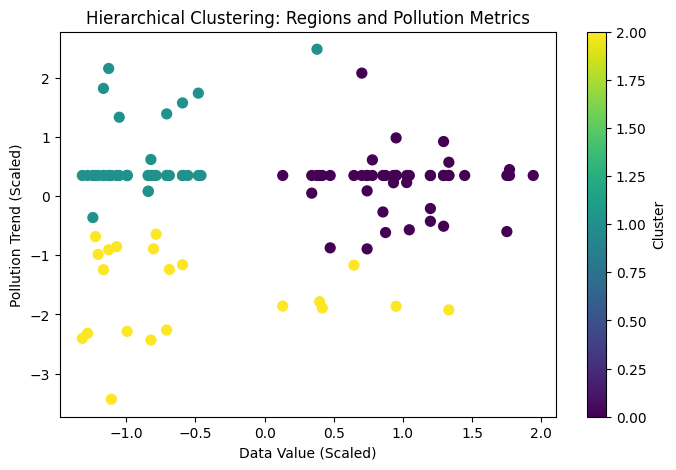

In [21]:
# Scatter plot of clusters
plt.figure(figsize=(8, 5))
plt.scatter(scaled_data['Data Value'], scaled_data['Pollution_Trend'], c=region_filtered_data['Cluster'], cmap='viridis', s=50)
plt.title('Hierarchical Clustering: Regions and Pollution Metrics')
plt.xlabel('Data Value (Scaled)')
plt.ylabel('Pollution Trend (Scaled)')
plt.colorbar(label='Cluster')
plt.show()